## Imports

In [35]:
%reset

Nothing done.


In [126]:
import edec.afterprocessing as ap
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
%matplotlib inline

## Functions

In [127]:
def import_labels(label=1, db="df.db",n_random=10):
        """
        This function import all cars from sql with stated label 0/1
        Example: Car "abc" and "bcd" has at some point been labeled with a Cell fail 1

        tin_an  Fail
        "abc"   0
        "abc"   1
        "abc"   0
        "bcd"   0
        "bcd"   0
        "bcd"   1
        """
        # Select all cell fails
        # limit the result to only x for non fail cars
        #if label == 0:
        #        lim = "LIMIT 3"
        #else:
        #        lim = ""

        ## SELECT ALL UNIQUE CARS WITH 0 / 1
        """
        First sub query select lim random number of tin numbers with label 
        Seccond query select timestamp, sorted soc etc from the sub_query
        
        """

        #if label == 0:
                #n_random = 100
        #if label == 1:
               # n_random = 1000
                
        sub_query  = f"SELECT DISTINCT(main_table.tin_an) FROM main_table \
                        INNER JOIN cell_fail \
                        ON main_table.rid = cell_fail.rid \
                        AND cell_fail.Fail = {label} \
                        ORDER BY RANDOM() \
                         LIMIT {n_random}"

        query = f"SELECT main_table.tin_an, [timestamp], [Sorted_SOC], cell_fail.Fail FROM main_table \
                INNER JOIN cell_fail \
                ON main_table.rid = cell_fail.rid \
                WHERE [tin_an] in ({sub_query})"

        df = ap.load_sql(query , db=db)

        # Change to Timestamp format
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        # Sort by timestamp
        df = df.sort_values(by=["timestamp"],ascending=True)

        # Print import result
        n_unique = len(df["tin_an"].unique())
        print(f"{n_unique} Unique cars with label {label} has been imported with {len(df)} subsamples")
        return df

def sample_to_tensor_x(df_tensor, sub_samples=3):
    x = torch.zeros(sub_samples,108) # 20 as we use 20 subsample cars
    i_from = len(df_tensor) - sub_samples
    i_to =  len(df_tensor)

    for tensor_i, df_i in enumerate(reversed(range(i_from, i_to))):
        carcell_voltage = df_tensor["Sorted_SOC"].iloc[df_i]     
        x[tensor_i] = torch.FloatTensor(carcell_voltage)
    return x


def create_dataset(db="df.db", parameters=None, normalize_data=False):
    # Output
    data = []
    run_details = {"Fail types loaded":0, 
                    "Samples removed":{
                                        0:0, 
                                        1:0,
                                        },
                    "Dropped tin":{
                                    0:[],
                                    1:[]},
                                    }

        
    # Paramters
    roll = parameters["roll"]
    sub_sample = parameters["Sub sample"]
    drop_sample = parameters["drop_sample"]+1 #Definierar 0 som ingen drop, men måste lägga till 1 pga att loopen f

    for fail in range(2): ##################################################################### ÄNDRA TILL 2
        run_details["Fail types loaded"] +=1
        print(f"Run {fail} started")
        # Create df with 0 and 1
        df = import_labels(label=fail, db=db, n_random = parameters["nRandom samples"][fail])
        cars = df["tin_an"].unique()
        print(f"{len(cars)} Cars in df")
        for i_car in range(len(cars)): # Change to 2

            # Get unique tin_number for fail / healthy
            df_tin = df[df["tin_an"] == cars[i_car]]
            df_tin = df_tin.reset_index()
            if fail == 1:
                max_index  = df_tin[df_tin["Fail"] == 1].index.values
                last_idx = max_index[-1]
                df_tensor = df_tin[:last_idx+1]
            else:
                last_idx = len(df_tin) +1 #-1
                df_tensor = df_tin[:last_idx+1]


            #for roll in range(1,5):
                #display(df_tensor[-roll-sub_sample:-roll])

            ### Create rolling
            # 1 should be standard
            last_idx_temp = last_idx
            for r in range(1,roll+1):
                #df_tensor_short = df_tensor[last_idx_temp-(parameters["Sub sample"]):last_idx_temp+1]
                df_tensor_short = df_tensor[-r-sub_sample:-r]
                last_idx_temp -= 1

                #if len(df_tensor_short) < parameters["Sub sample"]:
                    #   min_length = parameters["Sub sample"]
                    #   print(f"Skipping df. df_tensor length {len(df_tensor_short)}. (min lentht {min_length})")

                # Create database
                if (len(df_tensor_short) >= (sub_sample)) & (r >= (drop_sample)):
                #if (len(df_tensor_short) >= (sub_sample)) & (r > (drop_sample)):
                #if (len(df_tensor_short) >= (sub_sample)):
                    x = sample_to_tensor_x(df_tensor_short, sub_samples=sub_sample)
                    if normalize_data:
                        #x = normalize(x, p=2, dim = 1) # 1 or 0 
                        # Normalize by xi - min(x) / (max(x) - min(x))
                        min_i = x.min().item()
                        max_i = x.max().item()
                        x = (x-min_i)/(max_i - min_i)
                    y = fail
                    data.append((x,y))
                if (len(df_tensor_short) < (sub_sample)):
                    run_details["Samples removed"][fail] +=1
                    run_details["Dropped tin"][fail].append(df_tensor["tin_an"].unique()[0])
                    #continue
    print(run_details)
    return data

In [128]:
#db = "df_10.db"
db = "df.db"

# Annotate data (ONLY RUN IF NEW ANNOTATION IS REQUIRED)
#ap.annotate_db(fail_type="SOC", db=db)

## Basic data analysis

In [4]:
query = f"SELECT DISTINCT(main_table.tin_an), cell_fail.Fail FROM main_table \
        INNER JOIN cell_fail \
        ON main_table.rid = cell_fail.rid"

df_count = ap.load_sql(query , db=db)
df_count.groupby("Fail").count()

,tin_an
Fail,
0,18575
1,369


## Select parameters for data creation

In [149]:
"""Paramater values:

Sub_sample: How mmany timesamples backwards should be included (0 only give 1 sample, i.e [1,108])
drop_sample: How many samples should be dropped (0 for no drop). DROP SAMPLE MUST BE LARGER THAN ROLL
roll: How many timesteps back should we roll (1 for no rolling) 
"""
parameters = {"nRandom samples":{
                                0 : 20,
                                1 : 20,
                                },
            "Sub sample":20,
            "drop_sample":0, # Default 0
            "roll":5         # Default 1 (Must be larger or equal to subsample)
            }

In [150]:
data =create_dataset(db="df.db", parameters=parameters, normalize_data=True)

Run 0 started
20 Unique cars with label 0 has been imported with 3067 subsamples
20 Cars in df
Run 1 started
20 Unique cars with label 1 has been imported with 3634 subsamples
20 Cars in df
{'Fail types loaded': 2, 'Samples removed': {0: 6, 1: 34}, 'Dropped tin': {0: ['3cc368a9a91a8ff45b31de9f707b1d210e9d6f70a451dfc2da2e038e3ad287ec', '3cc368a9a91a8ff45b31de9f707b1d210e9d6f70a451dfc2da2e038e3ad287ec', '3cc368a9a91a8ff45b31de9f707b1d210e9d6f70a451dfc2da2e038e3ad287ec', '3cc368a9a91a8ff45b31de9f707b1d210e9d6f70a451dfc2da2e038e3ad287ec', '3cc368a9a91a8ff45b31de9f707b1d210e9d6f70a451dfc2da2e038e3ad287ec', '3f55d2d21e9fd9e921101fb3d82fd8fdbefc6128d55ed894e226e12878626c66'], 1: ['36a48fe41b39d708172a7e612a2aa76ef3ef389dfbea33ac03708c75a936c330', '36a48fe41b39d708172a7e612a2aa76ef3ef389dfbea33ac03708c75a936c330', '36a48fe41b39d708172a7e612a2aa76ef3ef389dfbea33ac03708c75a936c330', '36a48fe41b39d708172a7e612a2aa76ef3ef389dfbea33ac03708c75a936c330', '36a48fe41b39d708172a7e612a2aa76ef3ef389dfbea3

In [151]:
data

[(tensor([[0.5816, 0.5791, 0.5805,  ..., 0.5860, 0.5857, 0.5850],
          [0.8202, 0.8176, 0.8189,  ..., 0.8238, 0.8237, 0.8228],
          [0.5412, 0.5381, 0.5399,  ..., 0.5456, 0.5451, 0.5443],
          ...,
          [0.3831, 0.3807, 0.3825,  ..., 0.3906, 0.3892, 0.3880],
          [0.4478, 0.4438, 0.4459,  ..., 0.4509, 0.4496, 0.4492],
          [0.5356, 0.5310, 0.5333,  ..., 0.5393, 0.5381, 0.5376]]),
  0),
 (tensor([[0.8202, 0.8176, 0.8189,  ..., 0.8238, 0.8237, 0.8228],
          [0.5412, 0.5381, 0.5399,  ..., 0.5456, 0.5451, 0.5443],
          [0.7267, 0.7239, 0.7254,  ..., 0.7309, 0.7304, 0.7299],
          ...,
          [0.4478, 0.4438, 0.4459,  ..., 0.4509, 0.4496, 0.4492],
          [0.5356, 0.5310, 0.5333,  ..., 0.5393, 0.5381, 0.5376],
          [0.9231, 0.9207, 0.9219,  ..., 0.9272, 0.9271, 0.9263]]),
  0),
 (tensor([[0.5412, 0.5381, 0.5399,  ..., 0.5456, 0.5451, 0.5443],
          [0.7267, 0.7239, 0.7254,  ..., 0.7309, 0.7304, 0.7299],
          [0.8644, 0.8619, 0.8

## Create dataset

In [131]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data,[train_size, test_size])
batch_size = 10
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,drop_last=True)

## Testa förhållandet 0 / 1 i train och test

In [132]:
val_0 = 0
val_1 = 0
for i in range(len(train_set)):
    if train_set[i][1] == 0:
        val_0 += 1
    if train_set[i][1] == 1:
        val_1 += 1
print((val_0)/(val_0+val_1))
print((val_1)/(val_0+val_1))


0.5704113924050633
0.4295886075949367


In [133]:
val_0 = 0
val_1 = 0
for i in range(len(test_set)):
    if test_set[i][1] == 0:
        val_0 += 1
    if test_set[i][1] == 1:
        val_1 += 1
print((val_0)/(val_0+val_1))
print((val_1)/(val_0+val_1))

0.5993690851735016
0.40063091482649843


In [134]:
for (X_train,y_train) in train_loader:
    break
X_train.shape


torch.Size([10, 20, 108])

## Create network

In [135]:
subsample  = parameters["Sub sample"]
subsample

20

In [136]:
class ANNMultilayerperceptron(nn.Module):

    def __init__(self, input_size=(subsample*108),output_size=2, layers=[220,84]):  # 120, 84
        super().__init__()

        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc2b = nn.Linear(layers[1], 500)
        self.fc2c = nn.Linear(500, layers[1])
        self.fc2d = nn.Linear(layers[1], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc2b(X))
        X = F.relu(self.fc2c(X))
        X = F.relu(self.fc2d(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1) # PGA multiclass classification
        #return X

In [137]:
model = ANNMultilayerperceptron()
model

ANNMultilayerperceptron(
  (fc1): Linear(in_features=2160, out_features=220, bias=True)
  (fc2): Linear(in_features=220, out_features=84, bias=True)
  (fc2b): Linear(in_features=84, out_features=500, bias=True)
  (fc2c): Linear(in_features=500, out_features=84, bias=True)
  (fc2d): Linear(in_features=84, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [138]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [139]:
from ignite.metrics import Precision, Recall
from ignite.metrics import Precision ### LÄGG TILL IGNITE
train_precision = Precision()
train_recall = Recall()

test_precision = Precision()
test_recall = Recall()
# https://pytorch.org/ignite/metrics.html


epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs 

for i in range(epochs):
    trn_correct = 0
    tst_correct = 0 

    # Train

    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Skip iteration if batch size not equal to stated dim
        
            
        #print(X_train.shape, y_train.shape) 
        
        b += 1
        
        y_pred = model(X_train.view(batch_size, -1))  # Flatten input
        lossTrain = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data,1)[1]

        #calculate precision and recall
        train_precision.update((y_pred, y_train))
        train_recall.update((y_pred, y_train))
      

        batch_corr = (predicted == y_train).sum()
        trn_correct += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        #if b%2 == 0:
           #print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()}")

    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_correct)

    # Test
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val = model(X_train.view(batch_size, -1))

            predicted = torch.max(y_val.data,1)[1]

            #calculate precision and recall
            test_precision.update((y_val, y_test))
            test_recall.update((y_val, y_test))
            
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(trn_correct)

        if b%5 == 0:
            print(f"Epoch {i} Batch: {b} Train Loss: {lossTrain.item()} Validation Loss: {loss.item()}")


Epoch 0 Batch: 30 Train Loss: 0.6794919967651367 Validation Loss: 0.6994456648826599
Epoch 1 Batch: 30 Train Loss: 0.6772847175598145 Validation Loss: 0.7093688249588013
Epoch 2 Batch: 30 Train Loss: 0.617722749710083 Validation Loss: 0.6706859469413757
Epoch 3 Batch: 30 Train Loss: 0.6888092756271362 Validation Loss: 0.6885554790496826
Epoch 4 Batch: 30 Train Loss: 0.6525634527206421 Validation Loss: 0.6534345746040344
Epoch 5 Batch: 30 Train Loss: 0.6497920751571655 Validation Loss: 0.6857483983039856
Epoch 6 Batch: 30 Train Loss: 0.6421738862991333 Validation Loss: 0.6731719374656677
Epoch 7 Batch: 30 Train Loss: 0.6856144666671753 Validation Loss: 0.6971727609634399
Epoch 8 Batch: 30 Train Loss: 0.6746363639831543 Validation Loss: 0.6442509293556213
Epoch 9 Batch: 30 Train Loss: 0.6740750074386597 Validation Loss: 0.6643325090408325
Epoch 10 Batch: 30 Train Loss: 0.656894862651825 Validation Loss: 0.6479921340942383
Epoch 11 Batch: 30 Train Loss: 0.7626415491104126 Validation Loss:

In [140]:
print(train_precision.compute())
print(train_recall.compute())
print(test_precision.compute())
print(test_recall.compute())

tensor([0.9564, 0.9747], dtype=torch.float64)
tensor([0.9816, 0.9406], dtype=torch.float64)
tensor([0.5980, 0.3987], dtype=torch.float64)
tensor([0.5865, 0.4102], dtype=torch.float64)


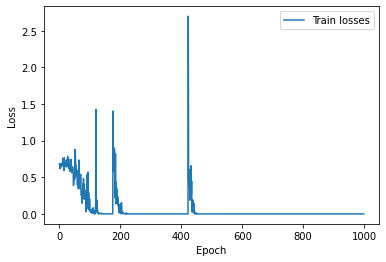

In [148]:

plt.plot(train_losses, label="Train losses")
#plt.plot(test_losses, label= "Test losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Predict a state of a single sample from test_set

In [153]:
import numpy as np
for _ in range(100):
    # Select random sample
    i = np.random.randint(1,len(test_set))
    x = test_set[i][0]
    y = test_set[i][1]


    # Evaluate on sample
    model.eval()
    with torch.no_grad():
        new_pred =model(x.view(1,-1))
        pred_int = int(torch.max(new_pred.data,1)[1])
    print(f"Random sample {i} selected with state {y}. Model predict state is {pred_int}")

Random sample 3 selected with state 0. Model predict state is 0
Random sample 228 selected with state 1. Model predict state is 0
Random sample 238 selected with state 1. Model predict state is 0
Random sample 58 selected with state 1. Model predict state is 1
Random sample 21 selected with state 1. Model predict state is 0
Random sample 200 selected with state 0. Model predict state is 0
Random sample 143 selected with state 0. Model predict state is 0
Random sample 237 selected with state 0. Model predict state is 1
Random sample 85 selected with state 1. Model predict state is 0
Random sample 30 selected with state 0. Model predict state is 0
Random sample 118 selected with state 0. Model predict state is 1
Random sample 253 selected with state 0. Model predict state is 0
Random sample 249 selected with state 0. Model predict state is 0
Random sample 22 selected with state 0. Model predict state is 0
Random sample 271 selected with state 0. Model predict state is 0
Random sample 149

## Predict a state of a single sample from train_set

In [154]:
import numpy as np
for _ in range(100):
    # Select random sample
    i = np.random.randint(1,len(train_set))
    x = train_set[i][0]
    y = train_set[i][1]


    # Evaluate on sample
    model.eval()
    with torch.no_grad():
        new_pred =model(x.view(1,-1))
        pred_int = int(torch.max(new_pred.data,1)[1])
    print(f"Random sample {i} selected with state {y}. Model predict state is {pred_int}")

Random sample 1087 selected with state 0. Model predict state is 0
Random sample 480 selected with state 1. Model predict state is 1
Random sample 120 selected with state 1. Model predict state is 1
Random sample 1216 selected with state 1. Model predict state is 1
Random sample 650 selected with state 1. Model predict state is 1
Random sample 109 selected with state 1. Model predict state is 1
Random sample 1135 selected with state 0. Model predict state is 0
Random sample 1033 selected with state 1. Model predict state is 1
Random sample 131 selected with state 1. Model predict state is 1
Random sample 1160 selected with state 0. Model predict state is 0
Random sample 619 selected with state 0. Model predict state is 0
Random sample 430 selected with state 1. Model predict state is 1
Random sample 1250 selected with state 0. Model predict state is 0
Random sample 456 selected with state 0. Model predict state is 0
Random sample 728 selected with state 1. Model predict state is 1
Rand